Assumptions: 
* Can represent $m_i$ as a linear combination of (potentially shifted) $m_p, \cdots, m_q \in \mathcal{N}^*(i)$. 
* Need to have reconstructed data over all time points where we are going to predict.
* $\exists \tau \geq 0: x_i(t) \approx x_j(t - \tau)$
* $\mathcal{A} = \left \{ A \in \mathbb{R}^{N \times N} \mid A^\top = A, A_{i, j} \geq 0 \forall i,j,   \right \}$ 

**Hypothesis**:
* The interpolated regions in our reconstructed screening histories exhibit patterns that can be organized into distinct sub-networks and our algorihtm is capable of indicating these networks.

**Approach**: 
* What kind of network do we seek?
    - A trade-off between global and local smoothness over graph signals.

In [357]:
from scipy import signal
from sklearn.linear_model import Ridge

from sklearn.metrics import pairwise_distances, jaccard_score

import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O

## Profile synthesis

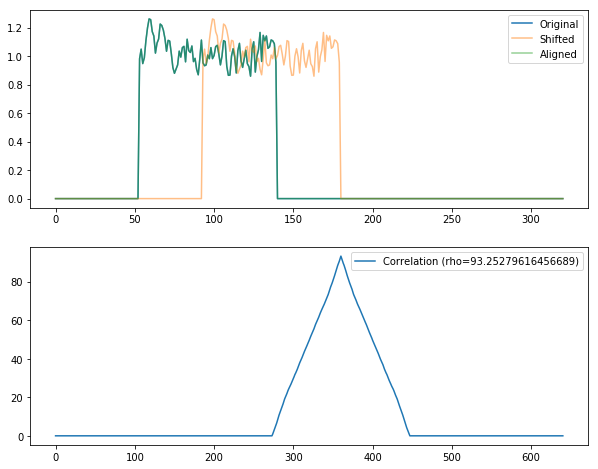

In [16]:
# Measure correlation.
q = Q[0]
q_shifted = Q_shifted[0]

C = signal.correlate(q_shifted, q) 
estimated_tau = np.argmax(C) + 1 - len(q)
correlation = max(C) + 1 - len(q)
c_shifted = np.zeros_like(q_shifted)

p = np.argmax(q_shifted != 0)
if estimated_tau > 0:
    k = p - estimated_tau
elif estimated_tau < 0:
    k = abs(estimated_tau) + p
else:
    k = p

if k < 0:
    sliced_c = q_shifted[q_shifted > 0][abs(k):]
    c_shifted[:len(sliced_c)] = sliced_c   
else:
    c_shifted[k:sum(q_shifted > 0) + k] = q_shifted[q_shifted > 0]

q_back_shifted = np.array(c_shifted)

fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
axes[0].plot(q, label="Original")
axes[0].plot(q_shifted, label=f"Shifted", alpha=0.5)
axes[0].plot(q_back_shifted, label="Aligned", alpha=0.5)
axes[0].legend()
axes[1].plot(C, label=f"Correlation (rho={max(C)})")
axes[1].legend()

# Algorithm

**Input**: A matrix $M$ containing the interpolated regions from the reconstructed screening data.

**Output**: An adjacency matrix $A$ minimizing a trade-off between the local and global smoothness over the graph signals $M$.

**Procedure** (infer adjacency matrix):
1. Initialize a neighbourhood $\mathcal{N}_i$ for each node $i$. 
2. Until convergence $\left \| A_{n + 1} - A_{n} \right \|_F ^2 < \epsilon$:
    1. Update $\mathcal{N}_n$ and compute $M^*$ using Sub-procedure 1. 
    2. Update $A_n$ according to Sub-procedure 2.
    3. Update $M_n$ according to Sub-procedure 3.
    5. Sample new neighbour candidates $\mathcal{N}_{n + 1}$ according to Sub-procedure 4.
  

**Sub-procedure 1** (update $\mathcal{N}$ and profile synthesis):
1. For each node $j \in \mathcal{N}_i$, if $\max_t (m_i \star m_j)(t) > \epsilon$:
    1. Assign $j$ to $\mathcal{N}_i^*$.
    2. Calculate the optimal shift $\tau^* = \arg \max_t (m_i \star m_j)(t)$ 
    3. Align $m_j$ to $m_i$ with $S^{\tau} m_j = m_j(t - \tau)$.
2. Let $\hat{m}_i = \sum_{j \in \mathcal{N}^*_i} m_j \beta^*_j$ for $\beta^*  = \min_{\beta, \sum_j \beta_j = 1} \left \| m_i - \sum_{j \in \mathcal{N}^*i} m_j \beta_j \right  \|_2^2 + \lambda \left \| \beta \right \|_2^2$.

**Sub-procedure 2** (update $A$):
1. Connect $i$ to $j \in \mathcal{N}^*_k(i)$ if $\mathcal{L}_n < \mathcal{L}_{n - 1} $ for $\mathcal{L}_n = \left \| m_i - \hat{m_i} \right \|_2^2$.
2. Use $\rho^* = \max_t (m_i \star m_j)(t)$ to weight the edge between $i$ and $j$.

**Sub-procedure 3** (update $M$):
1. Compute graph Laplacian $L$.
2. Solve $\min_{\hat{M}} \left \{ \alpha \left \| M - \hat{M} \right \|_F^2 + (1 - \alpha)\left \| M^* - \hat{M} \right \|_F^2 + \beta tr(\hat{M}^\top L \hat{M})  \right \}$ to adjust local and global smoothness of $M$.

**Sub-procedure 4** (sample new candidate neighbours):
1. Measure the neighbourhood overlap as the fraction of neighbors common to two nodes $i$ and $j$ using the Jaccard similarty $J = \frac{\mathcal{N}_i \cap  \mathcal{N}_j}{\mathcal{N}_i \cup \mathcal{N}_j}$ where $0 \leq J \leq 1$.
2. If $J = 1: i \rightarrow j$.
3. If $J < 0: J < 1 \Rightarrow \mathcal{N}_i \cup \mathcal{N}_j < \max \left \{ \left | \mathcal{N}_i \right |, \left | \mathcal{N}_j \right | \right \}$ so assign $k \in \mathcal{N}_i \setminus \mathcal{N}_j$ to $\mathcal{N}_j$ and assign $p \in \mathcal{N}_j \setminus \mathcal{N}_i$ to $\mathcal{N}_i$.

In [26]:
def synthetic_data_gen():
    
    M = np.load("../data/M_train.npy")
    Y = np.load("../data/X_train.npy")
    
    O = interpolation_region_mask(Y)

    return M * O
    
def screening_data_gen():
    
    M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
    Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
    O = interpolation_region_mask(Y)

    return M * O

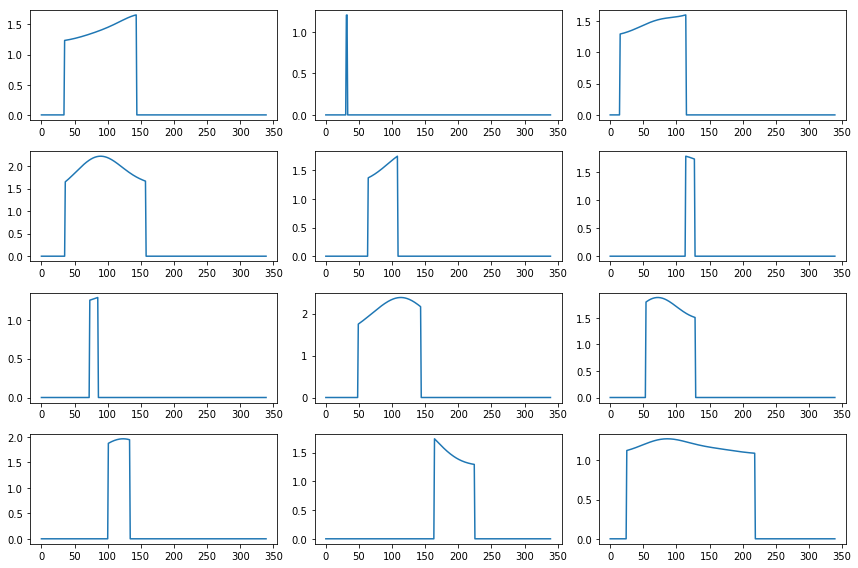

In [117]:
# Choose between synthetic and screening data for demonstration run.
M = synthetic_data_gen()
#M = screening_data_gen()

# Examples of profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
for i, axis in enumerate(axes.ravel()):
    axis.plot(M[i])
plt.tight_layout()

# Optimal alignment

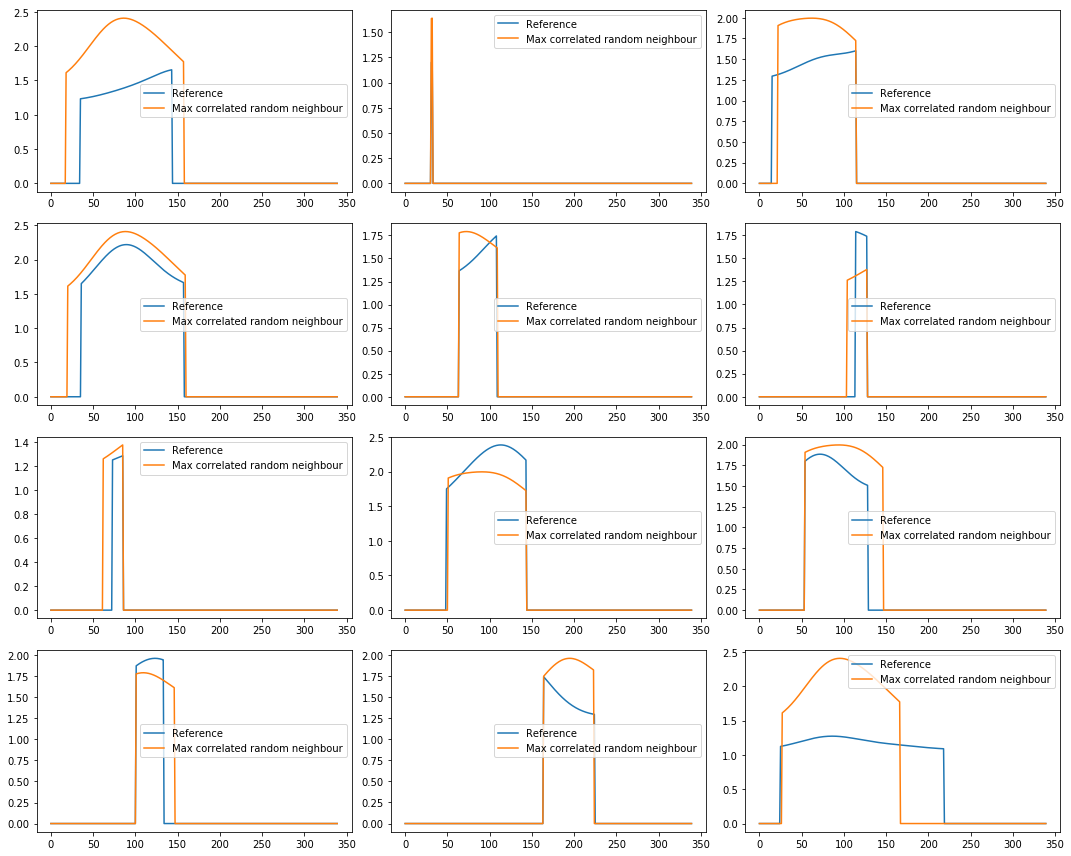

In [144]:
def cross_correlation(i, N_i, M, thresh=0.5):
    
    # TODO: Put checks in helper func.
    if isinstance(N_i, (int, float)):
        N_i = np.array([int(N_i)])
        
    if not isinstance(N_i, np.ndarray):
        N_i = np.array(N_i)
        
    if np.ndim(N_i) < 1:
        N_i = np.expand_dims(N_i, axis=0)
        
    N_i_star, T_i_star, C_i_star = [], [], []
    for j, m_j in enumerate(M[N_i]):
    
        c = signal.correlate(m_j, M[i]) 

        c_max = max(c) / sum(c != 0)
        if c_max > thresh:
                   
            T_i_star.append(np.argmax(c) + 1 - len(m_j))
            C_i_star.append(c_max)
            
            # NOTE: Retain only the neighbours sufficiently correlated.
            N_i_star.append(N_i[j])

    return T_i_star, C_i_star, N_i_star


def align(C, taus):
    
    if not taus:
        raise ValueError("Neighbourhood empty.")
    
    C_aligned = []
    for c, tau in zip(C, taus):
        
        p = np.argmax(c != 0)
        
        if tau > 0:
            k = p - tau
            
        elif tau < 0:
            k = abs(tau) + p

        else:
            k = p
        
        c_shifted = np.zeros_like(c)
        
        if k < 0:

            sliced_c = c[c > 0][abs(k):]   
            c_shifted[:len(sliced_c)] = sliced_c

        else:
            c_shifted[k:sum(c > 0) + k] = c[c > 0]
        
        C_aligned.append(c_shifted)
        
    return np.array(C_aligned)


# Find optimal alignment of two random profiles.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demosntration).
    np.random.seed(42)
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))
    
    # Find optimal alignment of elegible neighbours.
    T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0.5) 
    aligned_neighbours = align(M[N_i_star], T_i_star)

    # Display most correlated profiles.
    axis.plot(M[i], label="Reference")
    axis.plot(aligned_neighbours[np.argmax(C_i_star)], label="Max correlated random neighbour")
    axis.legend()
plt.tight_layout()

# Profile synthesis

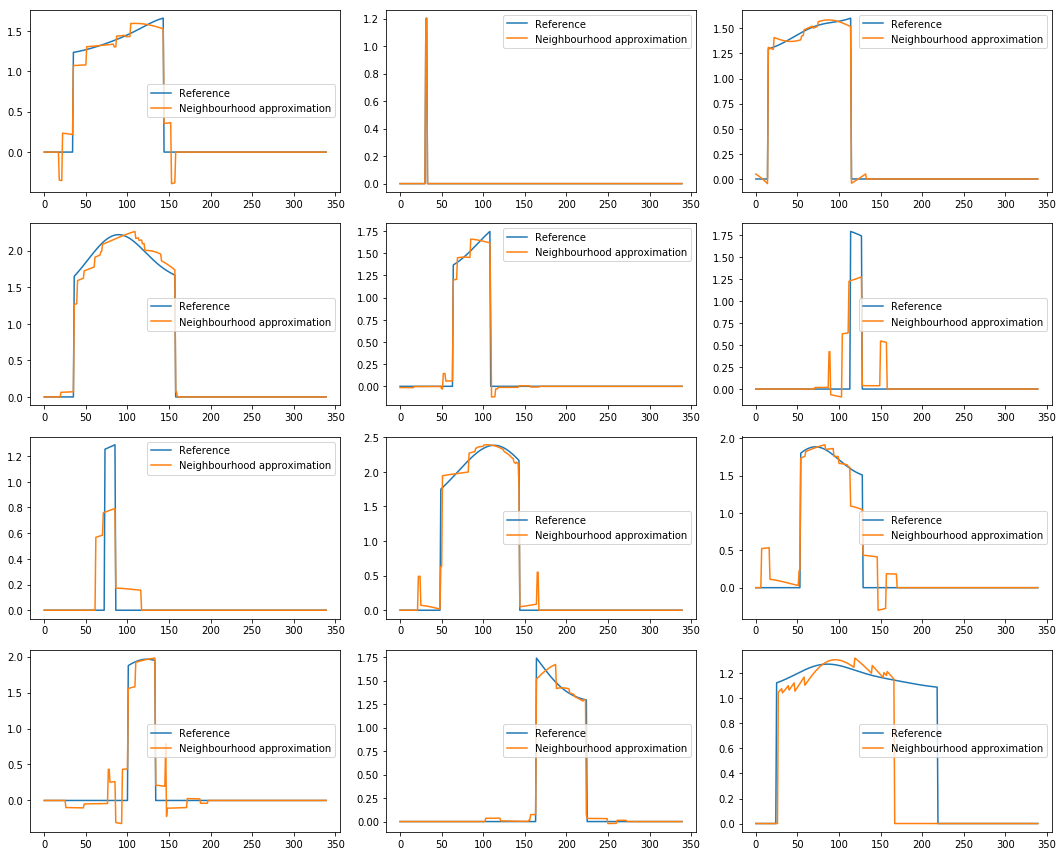

In [353]:
# TODO: Beta should be convex combination.
def synthesize(i, m_i, N_i, alpha=0):
        
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(np.transpose(N_i), m_i)
    
    return np.transpose(N_i) @ model.coef_


# Find use random profiles to approximate a reference profile.
_, axes = plt.subplots(ncols=3, nrows=4, figsize=(15, 12))
for i, axis in enumerate(axes.ravel()):
    
    # Select random neighbours (can also include self in this demosntration).
    np.random.seed(42)
    N_i = np.asarray(np.random.choice(range(M.shape[0]), size=10, replace=False))
    
    # Find optimal alignment of elegible neighbours.
    T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0.5) 
    aligned_neighbours = align(M[N_i_star], T_i_star)
    
    # Display most correlated profiles.
    axis.plot(M[i], label="Reference")
    axis.plot(synthesize(i, M[i], aligned_neighbours, alpha=0), label="Neighbourhood approximation")
    axis.legend()
    
plt.tight_layout()

# Update $A$

In [283]:
# NOTE: Here can also sovle som optimization to add global smoothness to A.
def update_adjacency(A, improved, N, C=None):
    """
    Args:
        A: Adjacency matrix in previous iteration.
        improved: Indicate improved loss with current neighbours.
        C (optional): Cross-correlation in node neighbourhoods.
    """
    
    A_new = A.copy().astype(float)

    to_update = np.squeeze(np.where(improved))
    for i in to_update:

        if not N[i]:
            continue

        # Erase previous neighbourhood.
        A_new[i, :] = 0
        A_new[:, i] = 0
        
        # Weighted.
        if C is not None:
            #print(C[i], i, N[i])
            A_new[i, N[i]] = C[i]
            A_new[N[i], i] = C[i]

        else:
            A_new[i, N[i]] = 1
            A_new[N[i], i] = 1

    # Just in case.
    np.fill_diagonal(A_new, 0)

    # Sanity check.
    assert np.array_equal(A_new, A_new.T)
    
    return A_new


# Demo run.
A = np.array([[0, 1, 1, 1],
              [1, 0, 1, 0],
              [1, 1, 0, 1],
              [1, 0, 1, 0]])

GT = np.array([[0, 0, 1, 1],
               [0, 0, 0, 0],
               [1, 0, 0, 1],
               [1, 0, 1, 0]])

N_star = [[2, 3], [], [0, 3], [0, 2]]

# NOTE: `improved` indicates if this neighbourhood improves on the previous.
A_new = update_adjacency(A, improved=[True, True, True, False], N=N_star)
assert np.array_equal(A_new, GT)

C = [[0.5, 0.5], [], [10, 10], [-9, -9]]
print(update_adjacency(A, improved=[True, True, True, False], N=N_star, C=C))

[[ 0.   0.  10.   0.5]
 [ 0.   0.   0.   0. ]
 [10.   0.   0.  10. ]
 [ 0.5  0.  10.   0. ]]


# Update $M$

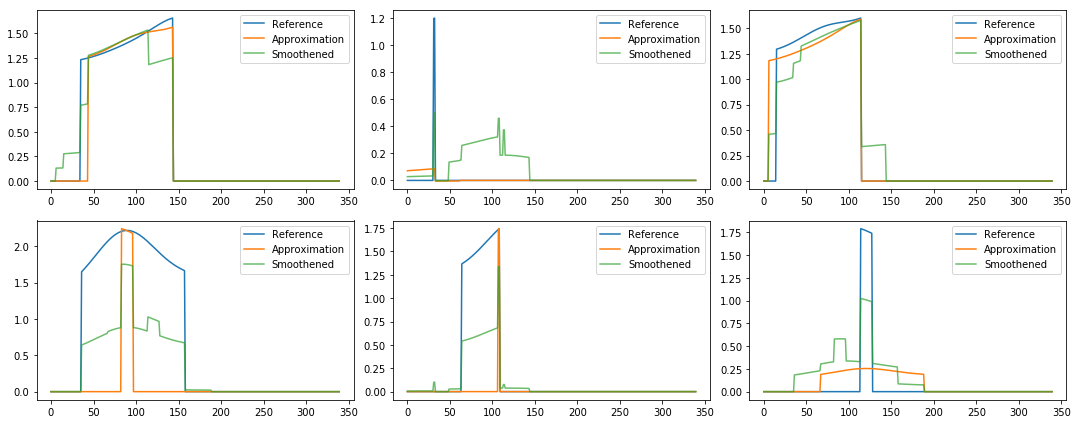

In [352]:
def approximate_M(M, A):

    M_star = []
    for i, a in enumerate(A):

        N_i = np.squeeze(np.where(a))
        if np.size(N_i) < 1:
            M_star.append(np.zeros_like(M[i]))
            continue

        T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M, thresh=0) 

        if np.size(N_i_star) < 1:
            M_star.append(np.zeros_like(M[i]))
            continue 

        m_i_hat = synthesize(i, M[i], align(M[N_i_star], T_i_star), alpha=0)
        M_star.append(m_i_hat)
        
    return np.array(M_star)

    
def smoothing(M, M_star, L, alpha=0.5, beta=0.5):
    """Solves \min_{\hat{M}} | M - \hat{M} |_F^2 + \gamma tr(\hat{M}^\top L \hat{M})."""
        
    return np.array(np.linalg.inv(np.eye(M.shape[0]) + beta * L) @ (alpha * M + M_star * (1 - alpha)))


# Random graph.
n = 8
G = nx.erdos_renyi_graph(n=n, p=0.05, seed=42, directed=False)
A = nx.to_numpy_array(G)
L = nx.normalized_laplacian_matrix(G).todense()

# Approximate each m_i using the randomly assigned neighbours.
M_star = approximate_M(M, A)

# Trade-off local and local smoothing.
M_hat = smoothing(M[:n], M_star, L, alpha=0.5, beta=0.4)

_, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 6))
for i, axis in enumerate(axes.ravel()):

    axis.plot(M[i], label="Reference")
    axis.plot(M_star[i], label="Approximation")
    axis.plot(M_hat[i], label="Smoothened", alpha=0.7)
    axis.legend()
    
plt.tight_layout()

# Sample new neighbours

In [484]:
# * Try a different adjacency matrix than the previous.
# * Change neighbourhoods in A based on overlap between existing neighbourhoods.
# * Makes the neighbourhoods of the two most similar neighbourhoods identical.


# See also: https://stackoverflow.com/questions/49733244/how-can-i-calculate-neighborhood-overlap-in-weighted-network
def neighbourhood_similarity(N_i, N_j):
    
    return jaccard_score(N_i, N_j)


def sample_candidate_neighbours(A):
    
    A_new = A.copy()
    
    to_update = np.arange(A.shape[0])
    while len(to_update) > 2:

        np.random.seed(42)
        i = np.random.choice(to_update)

        # Neighbourhoods to compare with N_i.
        candidates = np.random.choice(to_update, size=min(len(to_update), 3), replace=False)
        
        # Remove i from update set.
        to_update = np.setdiff1d(to_update, i)

        max_overlap = 0
        j = None
        for num, c in enumerate(candidates):

            score = neighbourhood_similarity(A[i], A[c])
            if score > max_overlap:

                max_overlap = score 
                j = c

        if max_overlap == 1:

            # Connect i and j.
            A_new[i, j] = 1
            A_new[j, i] = 1

        else:

            # Union of both neighbourhoods.
            N_new = np.logical_or(A[i], A[j])

            # Add neighbours from j to i and i to j.
            A_new[i, N_new] = 1
            A_new[N_new, i] = 1

        # Remove j from update set.
        to_update = np.setdiff1d(to_update, j)
        
    return A_new


# Demo run.
n = 5
G = nx.erdos_renyi_graph(n=n, p=0.3, seed=42, directed=False)
A = nx.to_numpy_array(G)
print(A)
print()

A_new = sample_candidate_neighbours(A)
print(A_new)

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]

[[0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1.]]


In [ ]:
def initialize(M, alpha=1):
    
    A = random()
    np.diagonal(A, 0)
    
    L, C_star, N_star = [], [], []
    for i, N_i in enumerate(A):
        
        T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M)
        
        m_i_hat = synthesize(align(M[N_i_star], T_i_star), i, N_i_star, alpha=alpha)
            
        L.append(np.linalg.norm(m_i_hat - M[i]))
    
        C_star.append(C_i_star)
        N_star.append(N_i_star)
        
    A = update_adjacency(A, improved=L < L_prev, N=N_star, C=C_star)
    
    return A, np.asarray(L)

In [ ]:
def main(M, alpha=1, k=10):
    
    # Run one iteration to initialize variables.
    A, L_prev = intialize(M)
    
    for _ in range(num_epochs):
        
        A, N_star, C_star, L = run_step(M, L_prev, alpha=alpha, k=k)
        
        if np.linalg.norm(A - A_prev) < eps:
            return A, M
        
        A_prev = A
        L_prev = L
        
        A = select_new_neighbours(A, N_star, C_star)
        
    return A, M

In [ ]:
def run_step(A, M, alpha=1, k=10):
        
    L, C_star, N_star = [], [], []
    for i, N_i in enumerate(A):
        
        T_i_star, C_i_star, N_i_star = cross_correlation(i, N_i, M)
        
        m_i_hat = synthesize(align(M[N_i_star], T_i_star), i, N_i_star, alpha=alpha)
        
        # Evaluate if current neighbourhood improved loss.
        L.append(np.linalg.norm(m_i_hat - M[i]))
    
        C_star.append(C_i_star)
        N_star.append(N_i_star)
        
    A = update_adjacency(A, improved=L < L_prev, N=N_star, C=C_star)
    
    return A, N_star, C_star, L